In [12]:
# Chunk 1: Imports and Data Preparation
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from urllib.request import urlopen
import ssl
from sklearn.preprocessing import LabelEncoder

def load_titanic_data():
    url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
    
    # Disable SSL verification
    context = ssl._create_unverified_context()
    df = pd.read_csv(urlopen(url, context=context))
    
    # Preprocessing
    def preprocess_data(df):
        features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
        target = 'Survived'
        
        df['Age'].fillna(df['Age'].median(), inplace=True)
        df['Fare'].fillna(df['Fare'].median(), inplace=True)
        df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
        
        le = LabelEncoder()
        df['Sex'] = le.fit_transform(df['Sex'])
        df['Embarked'] = le.fit_transform(df['Embarked'])
        
        X = df[features]
        y = df[target]
        
        return X, y

    return preprocess_data(df)

In [13]:
# Chunk 2: Neural Network Architecture
class TabularActivationNetwork(nn.Module):
    def __init__(self, input_size, activation_functions):
        super(TabularActivationNetwork, self).__init__()
        
        self.activation_map = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(),
            'softmax': nn.Softmax(dim=1)
        }
        
        self.activations = [self.activation_map.get(act.lower(), nn.ReLU()) for act in activation_functions]
        
        self.layers = nn.ModuleList([
            nn.Linear(input_size, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 1)
        ])
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = self.activations[i](x)
        x = torch.sigmoid(self.layers[-1](x))
        return x

In [14]:
# Chunk 3: Training and Evaluation Function
def train_and_evaluate(X, y, activation_functions, optimizer_name='adam', learning_rate=0.01, epochs=100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)
    
    model = TabularActivationNetwork(X_train.shape[1], activation_functions)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) if optimizer_name.lower() == 'adam' else \
                optim.SGD(model.parameters(), lr=learning_rate) if optimizer_name.lower() == 'sgd' else \
                optim.RMSprop(model.parameters(), lr=learning_rate)
    
    criterion = nn.BCELoss()
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss.item():.4f}, Test Loss = {test_loss.item():.4f}")
    
    model.eval()
    with torch.no_grad():
        predictions = (model(X_test_tensor) > 0.5).float()
        y_pred = predictions.numpy()
        y_true = y_test_tensor.numpy()
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }
    
    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'metrics': metrics,
        'y_true': y_true,
        'y_pred': y_pred
    }


In [15]:
# Chunk 4: Visualization Function
def visualize_results(results):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    for name, result in results.items():
        plt.plot(result['train_losses'], label=f'{name} - Train Loss')
        plt.plot(result['test_losses'], label=f'{name} - Test Loss', linestyle='--')
    plt.title('Training and Test Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    x = np.arange(len(metrics))
    width = 0.2
    
    for i, (name, result) in enumerate(results.items()):
        metric_values = [result['metrics'][m] for m in metrics]
        plt.bar(x + i*width, metric_values, width, label=name)
    
    plt.title('Performance Metrics')
    plt.xticks(x + width, metrics)
    plt.ylabel('Score')
    plt.legend()
    
    plt.show()

In [18]:
# Chunk 5: Experiment Runner
X, y = load_titanic_data()
activation_combinations = [['relu', 'sigmoid', 'tanh', 'sigmoid'], ['relu', 'relu', 'relu', 'sigmoid'], ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'], ['tanh', 'tanh', 'tanh', 'sigmoid']]
optimizers = ['adam', 'sgd', 'rmsprop']
results = {}

for optimizer in optimizers:
    for i, activations in enumerate(activation_combinations, 1):
        experiment_name = f"{optimizer.upper()} - {' -> '.join(activations)}"
        print(f"\nRunning Experiment: {experiment_name}")
        result = train_and_evaluate(X, y, activation_functions=activations, optimizer_name=optimizer, learning_rate=0.01, epochs=100)
        results[experiment_name] = result




/var/folders/kv/8x_b9m997wx09dpfwv80n6ww0000gn/T/ipykernel_46800/310816177.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/var/folders/kv/8x_b9m997wx09dpfwv80n6ww0000gn/T/ipykernel_46800/310816177.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al


Running Experiment: ADAM - relu -> sigmoid -> tanh -> sigmoid
Epoch 0: Train Loss = 0.6951, Test Loss = 0.6711
Epoch 10: Train Loss = 0.5485, Test Loss = 0.5279
Epoch 20: Train Loss = 0.4465, Test Loss = 0.4364
Epoch 30: Train Loss = 0.4086, Test Loss = 0.4135
Epoch 40: Train Loss = 0.3928, Test Loss = 0.4406
Epoch 50: Train Loss = 0.3813, Test Loss = 0.4317
Epoch 60: Train Loss = 0.3730, Test Loss = 0.4396
Epoch 70: Train Loss = 0.3657, Test Loss = 0.4452
Epoch 80: Train Loss = 0.3587, Test Loss = 0.4519
Epoch 90: Train Loss = 0.3502, Test Loss = 0.4597

Running Experiment: ADAM - relu -> relu -> relu -> sigmoid
Epoch 0: Train Loss = 0.6724, Test Loss = 0.6647
Epoch 10: Train Loss = 0.4556, Test Loss = 0.4263
Epoch 20: Train Loss = 0.3988, Test Loss = 0.4388
Epoch 30: Train Loss = 0.3828, Test Loss = 0.4645
Epoch 40: Train Loss = 0.3666, Test Loss = 0.4560
Epoch 50: Train Loss = 0.3532, Test Loss = 0.4657
Epoch 60: Train Loss = 0.3383, Test Loss = 0.4749
Epoch 70: Train Loss = 0.3213

/Users/vighneshnama/Documents/SDT AIML/3rd Year/6th sem/Deep neural networks/SimpleNN for loss visuals/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vighneshnama/Documents/SDT AIML/3rd Year/6th sem/Deep neural networks/SimpleNN for loss visuals/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vighneshnama/Documents/SDT AIML/3rd Year/6th sem/Deep neural networks/SimpleNN for loss visuals/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedM

Epoch 20: Train Loss = 0.3898, Test Loss = 0.4266
Epoch 30: Train Loss = 0.4024, Test Loss = 0.4455
Epoch 40: Train Loss = 0.3759, Test Loss = 0.4367
Epoch 50: Train Loss = 0.3682, Test Loss = 0.4379
Epoch 60: Train Loss = 0.3619, Test Loss = 0.4385
Epoch 70: Train Loss = 0.3597, Test Loss = 0.4402
Epoch 80: Train Loss = 0.3559, Test Loss = 0.4325
Epoch 90: Train Loss = 0.3558, Test Loss = 0.4403

Running Experiment: RMSPROP - relu -> relu -> relu -> sigmoid
Epoch 0: Train Loss = 0.6687, Test Loss = 0.6054
Epoch 10: Train Loss = 0.4258, Test Loss = 0.4111
Epoch 20: Train Loss = 0.3969, Test Loss = 0.4265
Epoch 30: Train Loss = 0.3922, Test Loss = 0.4384
Epoch 40: Train Loss = 0.3721, Test Loss = 0.4548
Epoch 50: Train Loss = 0.3611, Test Loss = 0.4597
Epoch 60: Train Loss = 0.3806, Test Loss = 0.4698
Epoch 70: Train Loss = 0.3518, Test Loss = 0.4806
Epoch 80: Train Loss = 0.3390, Test Loss = 0.5064
Epoch 90: Train Loss = 0.3288, Test Loss = 0.5099

Running Experiment: RMSPROP - sigmoid

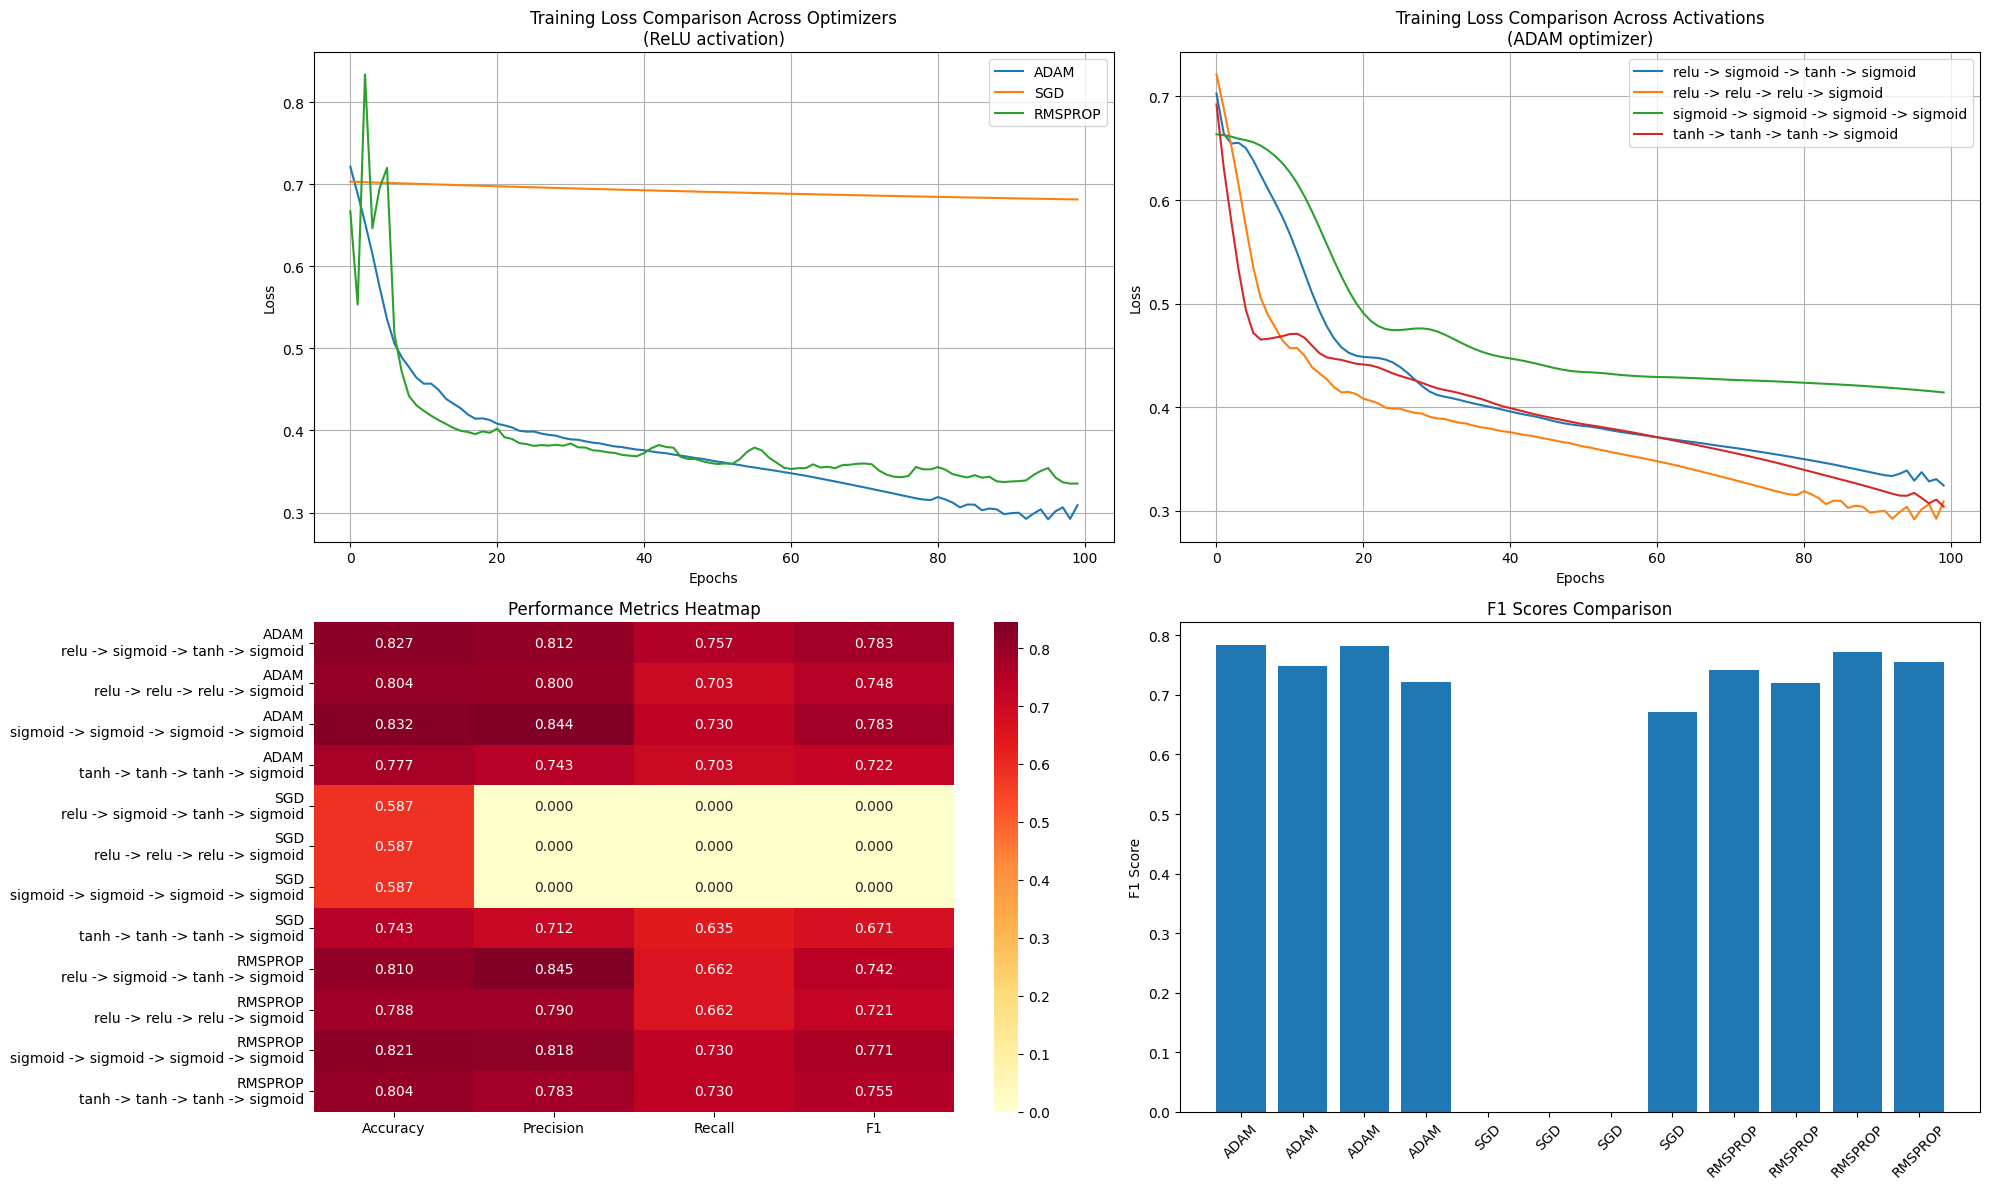

In [17]:
# Create improved visualizations with better clarity
plt.figure(figsize=(20, 12))

# Plot 1: Compare training losses across optimizers
plt.subplot(2, 2, 1)
for name, result in results.items():
    if 'relu -> relu -> relu -> sigmoid' in name:  # Compare same activation across optimizers
        plt.plot(result['train_losses'], label=name.split(' - ')[0])
plt.title('Training Loss Comparison Across Optimizers\n(ReLU activation)', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Compare different activation functions for ADAM
plt.subplot(2, 2, 2)
for name, result in results.items():
    if name.startswith('ADAM'):
        plt.plot(result['train_losses'], label=name.split(' - ')[1])
plt.title('Training Loss Comparison Across Activations\n(ADAM optimizer)', fontsize=12)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 3: Performance metrics heatmap
plt.subplot(2, 2, 3)
metrics_data = []
for name, result in results.items():
    metrics_data.append([
        result['metrics']['accuracy'],
        result['metrics']['precision'], 
        result['metrics']['recall'],
        result['metrics']['f1_score']
    ])

df_metrics = pd.DataFrame(
    metrics_data,
    columns=['Accuracy', 'Precision', 'Recall', 'F1'],
    index=[name.split(' - ')[0] + '\n' + name.split(' - ')[1] for name in results.keys()]
)

sns.heatmap(df_metrics, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Performance Metrics Heatmap', fontsize=12)

# Plot 4: Bar plot of F1 scores
plt.subplot(2, 2, 4)
f1_scores = [result['metrics']['f1_score'] for result in results.values()]
plt.bar(range(len(results)), f1_scores)
plt.xticks(range(len(results)), 
          [name.split(' - ')[0] for name in results.keys()],
          rotation=45)
plt.title('F1 Scores Comparison', fontsize=12)
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()